In [208]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from copy import deepcopy
import sys

In [210]:
def samples_shape_for_idx(data_idx):
    if data_idx == 0:
        from data import samples1, samples2, func
    elif data_idx == 1:
        from big_data import samples1, samples2, func
    elif data_idx == 2:
        from biggest_data import samples1, samples2, func
    elif data_idx == 3:
        from biggest_data2 import samples1, samples2, func
    elif data_idx >= 4:
        sys.argv[1] = data_idx
        from scattered import samples1, samples2, func
    return samples1, samples2

lines_pattern = '([^\s]+) : ([^\n]*)'
script_names_pattern = 'pmb_(\d+)_(\d+).py'

def handle_line(match):
    if len(match.group(2)) > 0:
        return match.group(1), float(match.group(2))
    else:
        return match.group(1), ""

def parse_file(filename):
    result = dict()
    
    data_idx = int(filename[6:filename.index('_')])
    result['data_idx'] = data_idx
    result['shapes'] = tuple(map(lambda s: s.shape, samples_shape_for_idx(data_idx)))
    
    result['max_distance'] = float(filename[filename.index('_')+1:filename.rindex('.')])
    
    best = (None,100000)
    with open("results/" + filename, "r") as file:
        data = file.read()
        
        by_bpc = {}
        by_bpa = {}
        pycsou = {}
        for script_name, time  in map(handle_line, re.finditer(lines_pattern, data)):
            match = re.search(script_names_pattern, script_name)
            if match:
                bpa, bpc = int(match.group(1)), int(match.group(2))

                if bpa not in by_bpa:
                    by_bpa[bpa] = []
                by_bpa[bpa].append((bpc, time))

                if bpc not in by_bpc:
                    by_bpc[bpc] = []
                by_bpc[bpc].append((bpa, time))
            else:
                pycsou[script_name[script_name.index('_')+1:-3]] = time
                
            if isinstance(time, float) and time < best[1]:
                best = (script_name, float(time))
                
        result['by_bpa'] = by_bpa
        result['by_bpc'] = by_bpc
        result['pycsou'] = pycsou
        result['best'] = best
    
    return result

In [199]:
def ticks_and_values(dc):
    ticks = []
    values = []
    secondary_keys = []
    for key, ls in sorted(dc.items()):
        for secondary_key, value in ls:
            ticks.append(key)
            values.append(value)
            secondary_keys.append(secondary_key)
    return ticks, values, secondary_keys

def plot_as_scatter(dc, logy=False, exclude=(), pycsou=['dask', 'sparse']):
    plt.title('samples1={}, samples2={}, Max distance={}'.format(*dc['shapes'], dc['max_distance']))
    
    # we make a copy to be sure
    dc = deepcopy(dc)
    
    primary_keys_sorted = sorted(list(dc['by_bpa'].keys()))
    for idx in exclude:
        print('excluding bpa={}'.format(primary_keys_sorted[idx]))
        dc['by_bpa'][primary_keys_sorted[idx]] = []
    
    ticks, values, secondary_keys = ticks_and_values(dc['by_bpa'])
    secondary_keys = list(secondary_keys)
    
    sc = plt.scatter(ticks, values, c=secondary_keys, s=100)
    
    plt.grid()
    if logy:
        plt.yscale('log')
    
    clb = plt.colorbar(sc, ticks=np.unique(secondary_keys))
    clb.ax.tick_params(labelsize=8) 
    clb.ax.set_title('Bins per chunk', fontsize=8)
    
    max_tick = max(filter(lambda val: len(dc['by_bpa'][val]) > 0, ticks))
    min_tick = min(filter(lambda val: len(dc['by_bpa'][val]) > 0, ticks))
    for p, color in zip(pycsou, ['r', 'g']):
        if not isinstance(dc['pycsou'][p], float):
            print('Skipping pycous-{} because data is not available'.format(p))
        plt.hlines(dc['pycsou'][p], min_tick, max_tick, color=color, label='Pycsou-{}'.format(p))
    
    plt.legend()
    plt.ylabel('Seconds')
    plt.xlabel('Bins per axis')
    
    plt.xticks(np.unique(ticks), np.unique(ticks))

In [212]:
outputs = sorted(os.listdir('results/'))
results = {(dc['data_idx'], dc['max_distance']) : dc for dc in map(parse_file, outputs)}

for idx, filename in enumerate(outputs):
    print('{} -> {}'.format(idx, filename))

0 -> output1_0.5.txt
1 -> output1_1.txt
2 -> output3_0.5.txt
3 -> output3_1.txt
4 -> output4_0.5.txt
5 -> output4_1.txt
6 -> output5_0.5.txt
7 -> output5_1.txt
8 -> output6_0.5.txt
9 -> output6_1.txt
10 -> output7_0.5.txt
11 -> output7_1.txt
12 -> output8_0.5.txt
13 -> output8_1.txt
14 -> output9_0.5.txt
15 -> output9_1.txt


excluding bpa=50


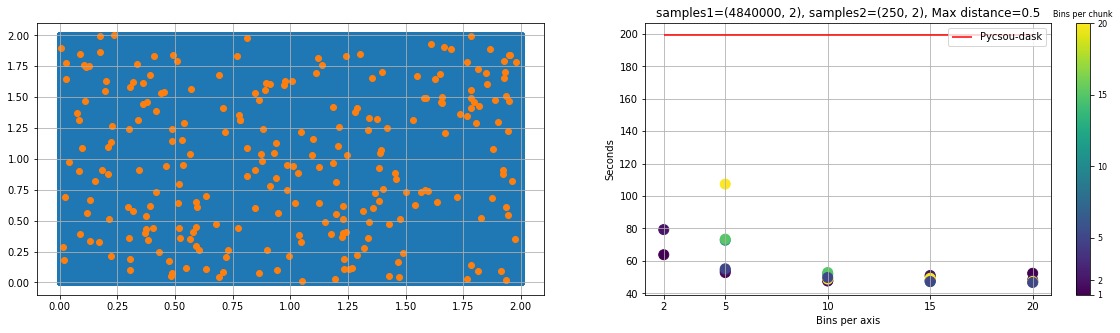

In [226]:
data_idx =3
distance = 0.5

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
samples1, samples2 = samples_shape_for_idx(data_idx)
plt.scatter(samples1[:,0], samples1[:,1], label='samples1')
plt.scatter(samples2[:,0], samples2[:,1], label='samples2')
plt.grid()

plt.subplot(1,2,2)
plot_as_scatter(results[(data_idx, distance)], exclude=(-1,), pycsou=['dask'])

plt.show()

## Scattered datasets

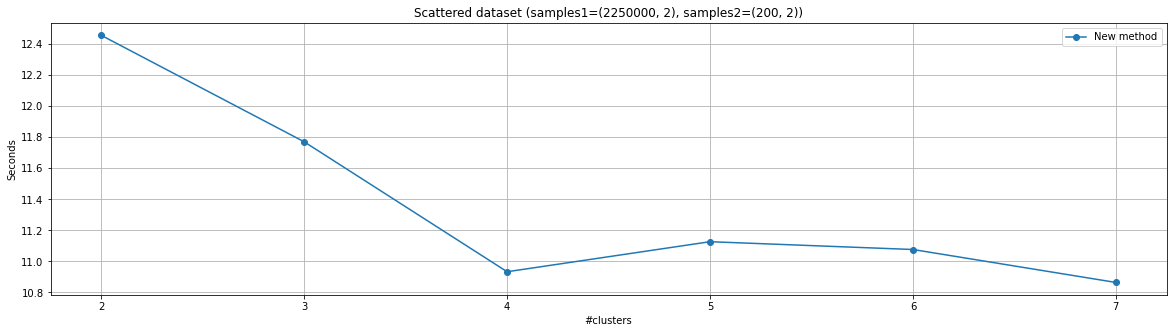

In [225]:
plt.figure(figsize=(20,5))

xs = list(range(4,10))

plt.plot(xs, [results[(xi, 0.5)]['best'][1] for xi in xs], '-o', label='New method')
#plt.plot(xs, [results[(xi, 0.5)]['pycsou']['dask'] for xi in xs], '-*', label='pycsou-dask')
#plt.plot(xs, [results[(xi, 0.5)]['pycsou']['sparse'] for xi in xs], '-.', label='pycsou-sparse')

plt.xticks(xs, np.array(xs) - 2)
plt.xlabel('#clusters')
plt.ylabel('Seconds')

plt.title('Scattered dataset (samples1={}, samples2={})'.format(
        *tuple(map(lambda s: s.shape, samples_shape_for_idx(5)))))
plt.grid()
plt.legend()

plt.show()